**Greetings, and welcome to ramannoodle!** This notebook contains a short tutorial, showcasing the API's workflow and capabilities. 

We'll import everything we'll need up front, as well add some customizations for matplotlib.

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

from ramannoodle import io
from ramannoodle.polarizability.interpolation import InterpolationPolarizabilityModel
from ramannoodle.symmetry import symmetry_utils
from ramannoodle.spectrum.spectrum_utils import convolve_intensities

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

We will be computing TiO2's Raman spectrum using data available in `tests/data/TiO2`. We will be basing this spectrum on frozen phonon calculations and use the InterpolationPolarizabilityModel to estimate phonon polarizabilities.

In [24]:
# phononsepseps_OUTCAR contains phonons (duh) as well as the equilibrium TiO2 structure.
phonon_outcar = "../test/data/TiO2/phonons_OUTCAR"

# Read the phonons
phonons = io.read_phonons(phonon_outcar, file_format = 'outcar')
# Read the symmetry of the structure. This might take a few moments...
symmetry = io.read_structural_symmetry(phonon_outcar, file_format = 'outcar')


Now that we have the structure's symmetry, we can start building the polarizability model.

In [27]:
# We'll need the polarizability of the equilibrium structure. 
_, equilibrium_polarizability = io.read_positions_and_polarizability(
   "../test/data/TiO2/ref_eps_OUTCAR", file_format = "outcar" 
)
model = InterpolationPolarizabilityModel(symmetry, equilibrium_polarizability)

We've set up `model`, but we are not yet ready to use it to predict polarizabilities. We'll need to add data! Specifically, we will walk through the system's symmetrically distinct degrees of freedom and add relevant polarizabilities for displacements along those degrees of freedom.

You can find the TiO2 supercell we're using for these calculations in `tests/data/TiO2/POSCAR`. Note that there are only **two** symmetrically distinct atoms - one Ti and one O. If we understand how movement of any one atom influences the polarizability, we can use symmetry to derive the behavior of the rest.  

Let's focus on a single Ti atom: atom 5 in our structure. Visualize the POSCAR mentioned above, for example using [VESTA](https://jp-minerals.org/vesta/en/). Think about displacing atom 5 along the x-axis. Convince yourself that displacements in the `+x` direction can be related by symmetry to displacements in the `-x` direction. We call these displacements **symmetrically equivalent**. 

Atom 5's displacement along the x-axis is a degree of freedom (DOF) of the system. Convince yourself that TiO2 structure contains many DOFs that are **symmetrically equivalent** to this DOF.

 The InterpolationPolarizabilityModel assumes that every DOF modulates the polarizability independently; it estimates this modulation using an interpolation around each DOF. We need to "add" each DOF to `model`, specifying specific displacements as well as polarizabilities for these displacements (which we calculate using VASP). The model's routines will take full advantage of symmetry to make our job much easier.

In [28]:
# OUTCARS are polarizability calculation where atom 5 (Ti) 
# was displaced +0.1 and +0.2 angstrom in the x direction
model.add_dof_from_files(
    ["../test/data/TiO2/Ti5_0.1x_eps_OUTCAR", "../test/data/TiO2/Ti5_0.2x_eps_OUTCAR"],
    file_format = 'outcar', interpolation_order=2)

# (36 equivalent Ti atoms) * (2 equivalent directions) --> 72 dofs should be added
print(f'Total interpolations: {len(model._interpolations)}')

Total interpolations: 72


We've added a total of 72 interpolations (i.e. 72 DOFs). Convince yourself that this makes sense.

In [29]:
# atom 5 moving +0.1 and +0.2 angstroms in the z direction
model.add_dof_from_files(["../test/data/TiO2/Ti5_0.1z_eps_OUTCAR",
                          "../test/data/TiO2/Ti5_0.2z_eps_OUTCAR"],
                            file_format = 'outcar', interpolation_order=2)

# (36 equivalent Ti atoms) * (1 equivalent direction) --> another 36 DOFs
print(f'Total interpolations: {len(model._interpolations)}')

Total interpolations: 108


Now, let's move on to the oxygen motions.

In [30]:
# atom 43 moving in the z direction
# Convince yourself that we need all of these displacements. 
model.add_dof_from_files(["../test/data/TiO2/O43_0.2z_eps_OUTCAR",
                          "../test/data/TiO2/O43_0.1z_eps_OUTCAR", 
                          "../test/data/TiO2/O43_m0.1z_eps_OUTCAR", 
                          "../test/data/TiO2/O43_m0.2z_eps_OUTCAR"], file_format= 'outcar', interpolation_order=2)

print(f'Total interpolations: {len(model._interpolations)}')

Total interpolations: 180


In [31]:
model.add_dof_from_files(["../test/data/TiO2/O43_0.1x_eps_OUTCAR",
                         "../test/data/TiO2/O43_0.2x_eps_OUTCAR"], 
                         file_format = 'outcar', interpolation_order=2)

print(f'Total interpolations: {len(model._interpolations)}')

Total interpolations: 252


In [32]:
model.add_dof_from_files(["../test/data/TiO2/O43_0.1y_eps_OUTCAR",
                          "../test/data/TiO2/O43_0.2y_eps_OUTCAR"],
                            file_format = 'outcar', interpolation_order=2)

# We should now have specified all 324 DOFs
print(f'Total interpolations: {len(model._interpolations)}')

Total interpolations: 324


The model should contain 324 interpolations, indicating that all 324 DOFs of the system are accounted for. Now, what do these interpolations look like?

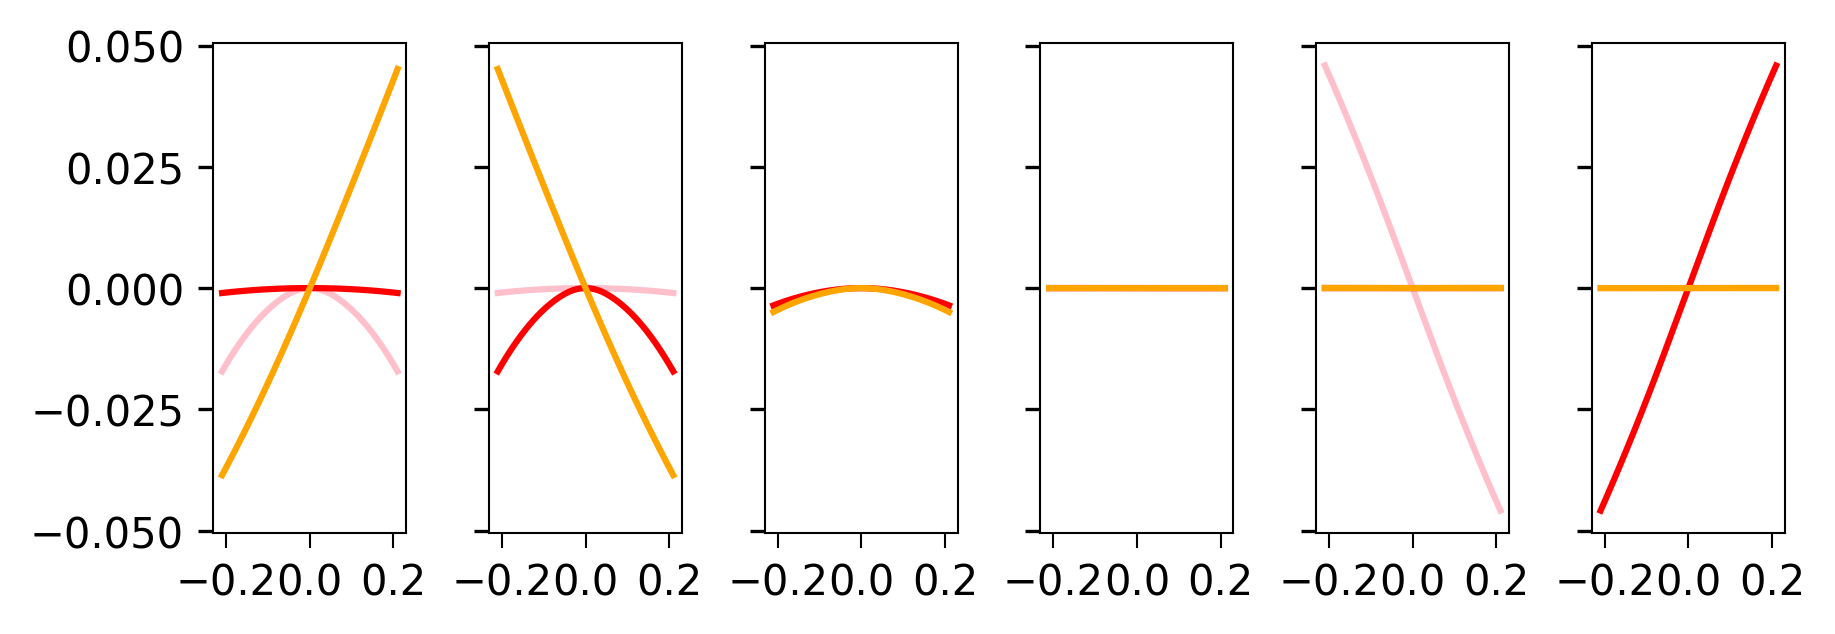

In [33]:
atom_number = 5 # Feel free to change this parameter to visualize the interpolations below.

fig = plt.figure(constrained_layout = True, figsize = (6, 2))
gs = fig.add_gridspec(1,6, wspace=0)
axes = gs.subplots(sharex=True, sharey=True)
interp_displacements = np.linspace(-0.21,0.21,50)

target_interps = []
signs = []
for direction_i in [0,1,2]:
    basis_vector = model._cartesian_basis_vectors[0] * 0
    basis_vector[atom_number-1][direction_i] = 1
    for basis, interp in zip(model._cartesian_basis_vectors,model._interpolations):
        if np.dot(basis.flatten(), basis_vector.flatten()) < -0.9:
            target_interps.append(interp)
            signs.append(-1)
        elif np.dot(basis.flatten(), basis_vector.flatten()) > 0.9:
            target_interps.append(interp)
            signs.append(1)


for axis_i, (i,j) in enumerate([(0,0),(1,1),(2,2),(0,1),(0,2),(1,2)]):
    axis = axes[axis_i]
    for interp,sign,color in zip(target_interps,signs,['pink', 'red', 'orange']):
        if sign < 0:
            print('negative sign')
        axis.plot(interp_displacements, 
                  interp(sign*interp_displacements)[:,i,j], color = color)

With the model specified, we're ready to calculate a Raman spectrum.

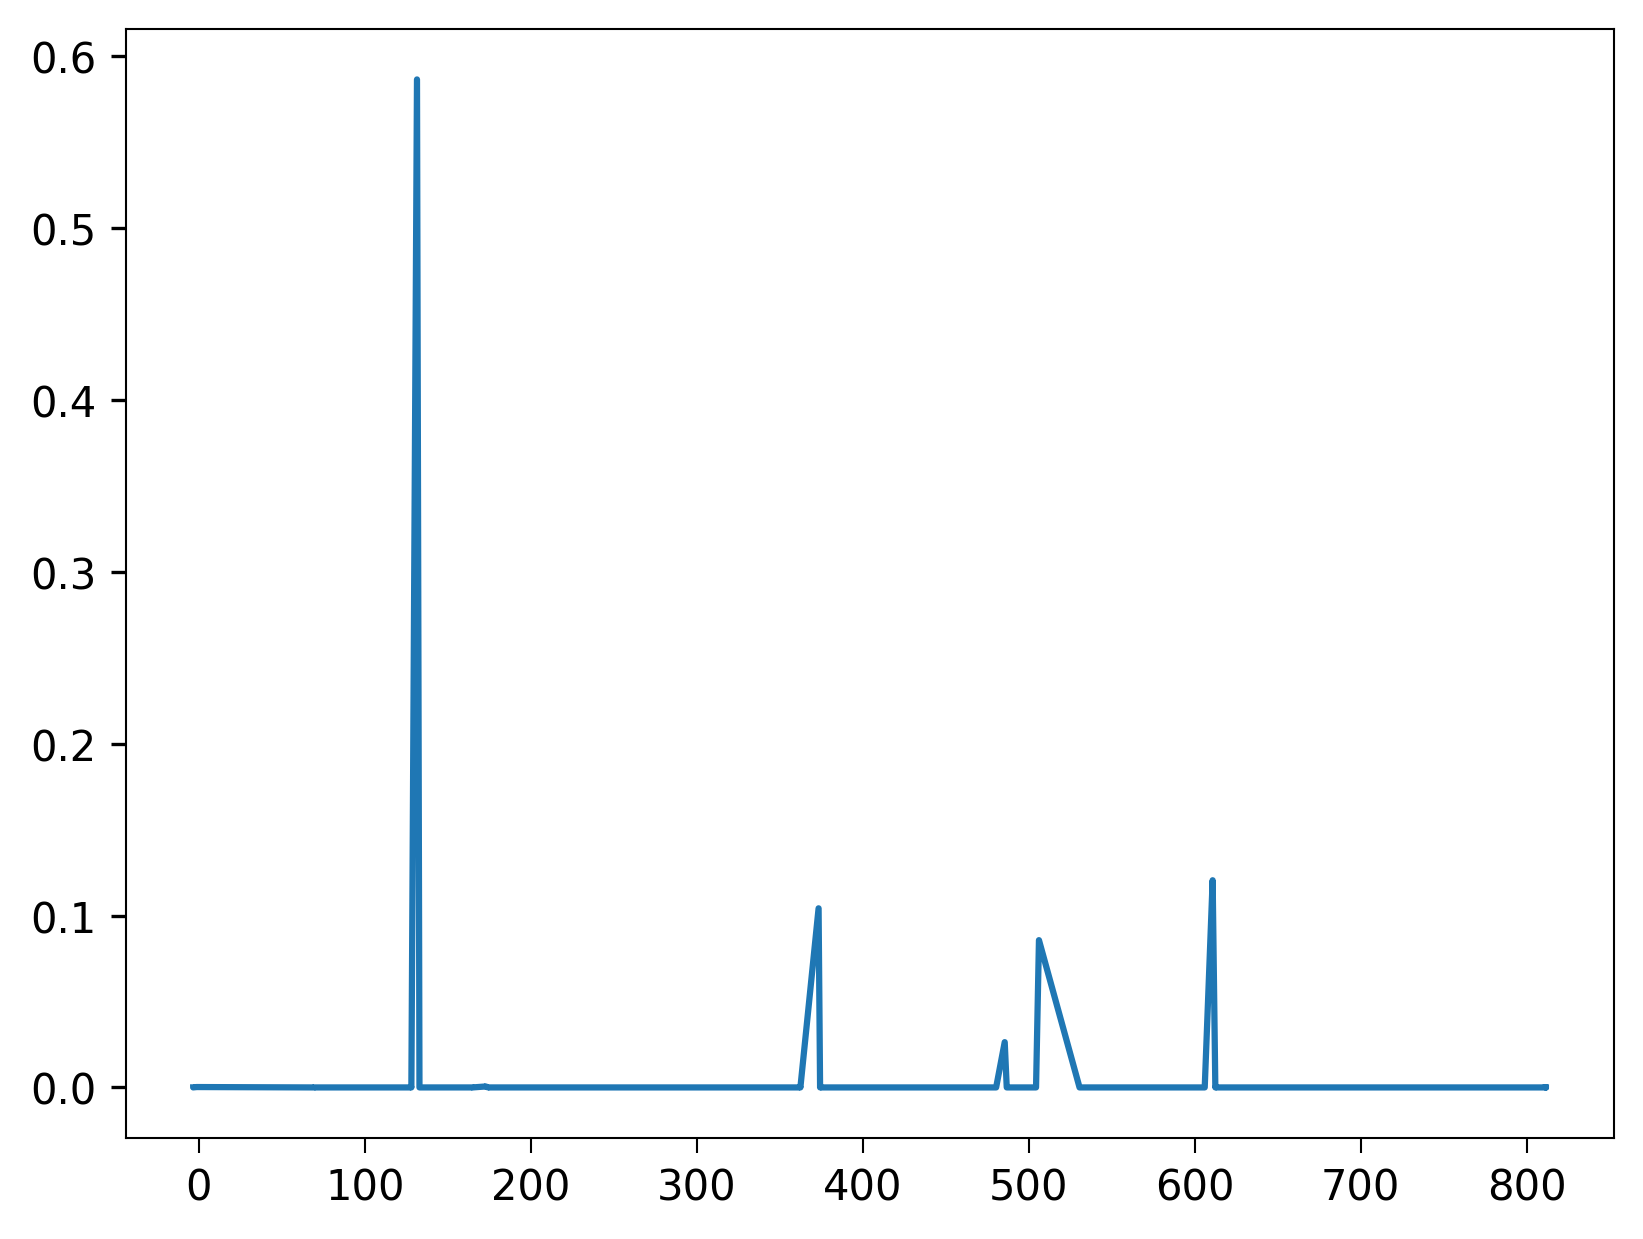

In [34]:
# Compute and plot spectrum
spectrum = phonons.get_raman_spectrum(model)
wavenumbers, intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(wavenumbers, intensities)

`spectrum.calculate` returns a fairly unprocessed spectrum - literally a list of phonon frequencies and intensities. To make a nicer, more realistic visualization, we can broaden the spectra through convolutions.

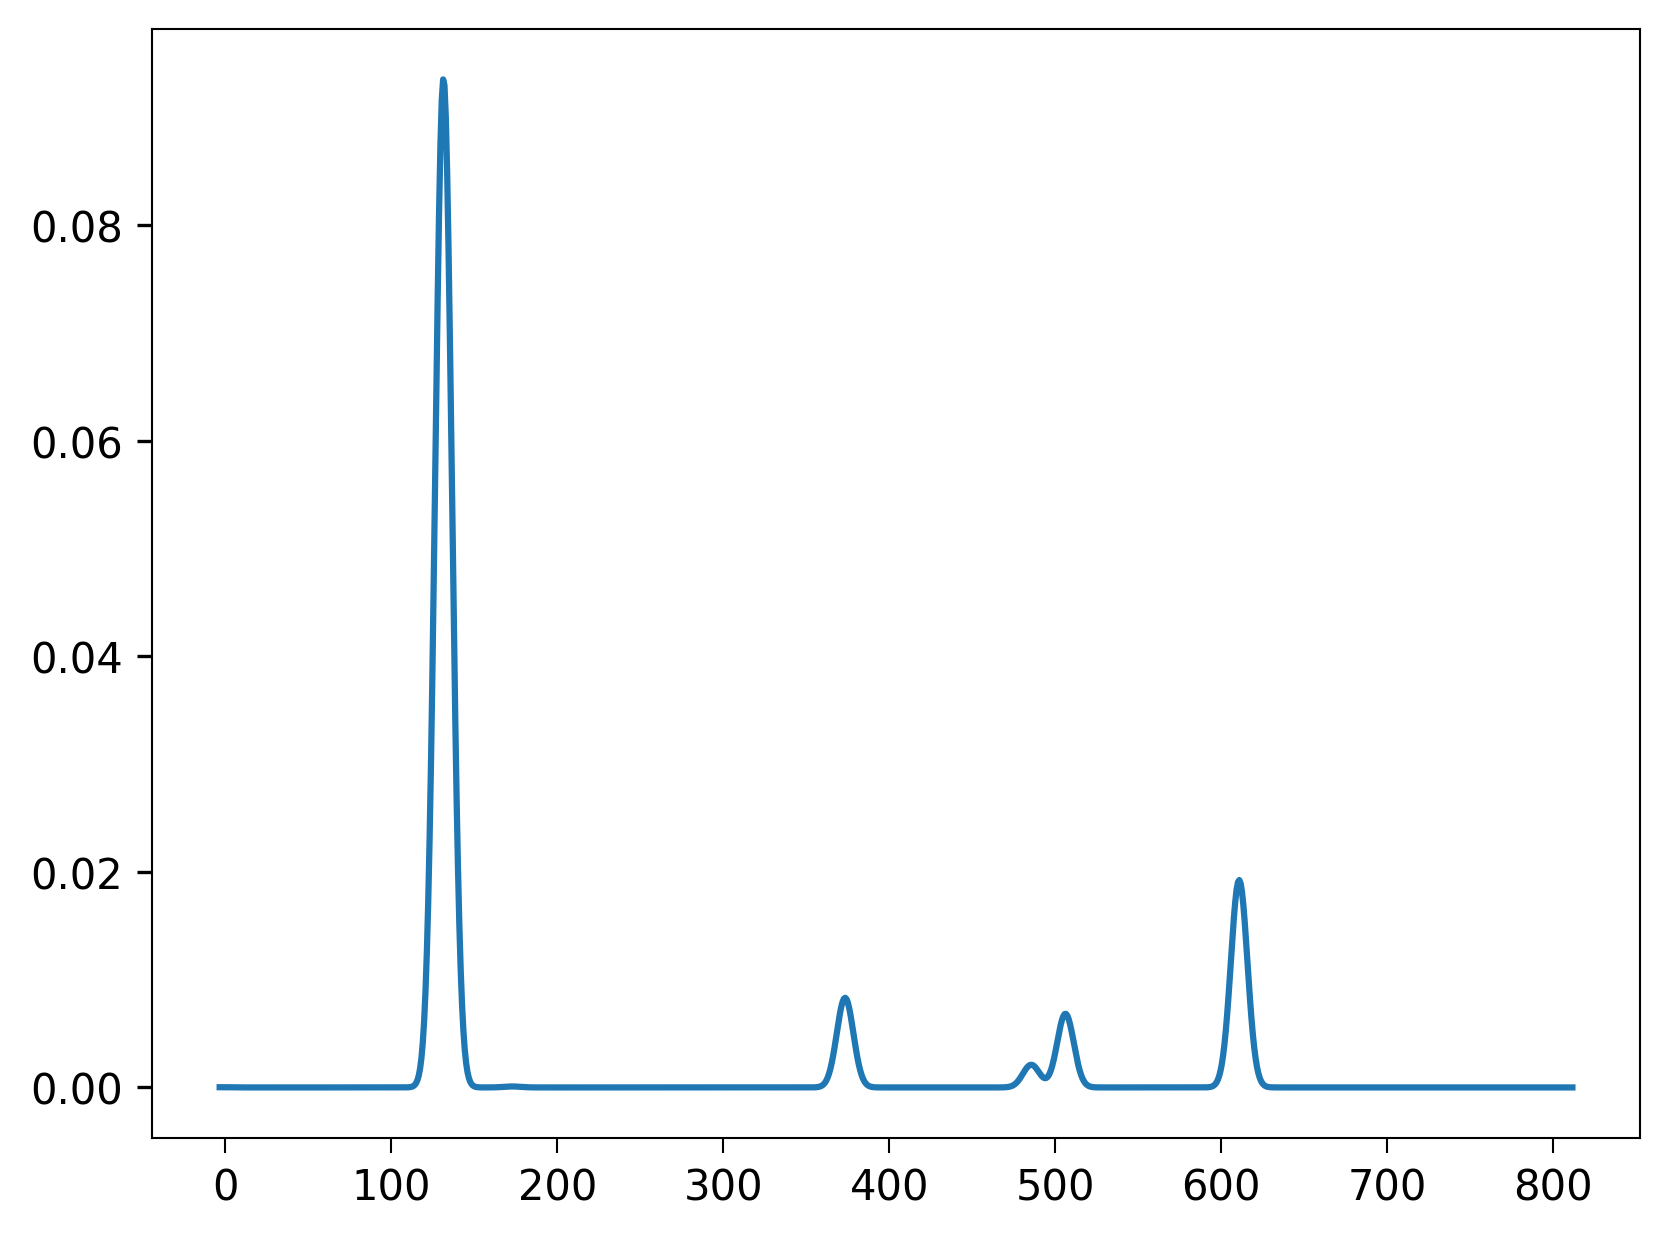

In [17]:
# Let's make it prettier. 
wavenumbers, intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
wavenumbers, intensities = convolve_intensities(wavenumbers, intensities)

fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(wavenumbers, intensities)
